# Circuit Model

A [circuit model](../_autosummary/photonforge.CircuitModel.rst) is one of the many model types supported by PhotonForge to calculate the [S parameters](S_Parameters.ipynb) of a component.
However, different from a [Tidy3D model](Tidy3D_Model.ipynb), for example, which calculates the S matrix based on the 3D extrusion of the component contents, the Circuit model uses the S matrices from the sub-components and combine them to calculate the global matrix.
For that, it delegates the computation of the sub-component S matrices to each sub-component's active model.

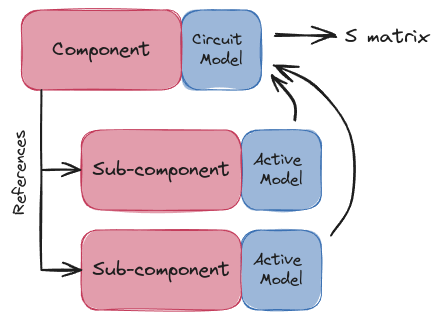

That also means that the circuit model **ignores all structures** directly placed in the main component (paths, polygons, etc. in the component's [structures](../_autosummary/photonforge.Component.rst#photonforge.Component.structures) list). It only uses the [referenced](../_autosummary/photonforge.Reference.rst) sub-components for the computation (found in the component's [references](../_autosummary/photonforge.Component.rst#photonforge.Component.references) list).

For demonstration purposes, we'll just connect 2 simple sub-components and show the Circuit model driving them.
More complete and realistic use cases are available in the [examples](../examples.rst).

In [1]:
import numpy as np
import photonforge as pf

pf.config.default_technology = pf.basic_technology()

In [2]:
sub_component1 = pf.parametric.straight(
    port_spec="Strip", length=1, active_model="Waveguide", name="SUB1"
)

sub_component2 = pf.parametric.straight(
    port_spec="Strip", length=2, active_model="Waveguide", name="SUB2"
)

main_component = pf.Component("MAIN")

ref1 = main_component.add_reference(sub_component1)
ref2 = main_component.add_reference(sub_component2)

# Connect port P0 from the second sub-component to port P1 from the first
ref2.connect("P0", ref1["P1"])

# Add ports to the main component based on the references' ports.
main_component.add_port([ref1["P0"], ref2["P1"]], "Port ")

main_component

## Connections

The Circuit model depends on the connections between sub-components to compute the overall S matrix.
The ports of the main component must also match sub-components ports, which we guaranteed by using the reference port instances when creating the main ports.

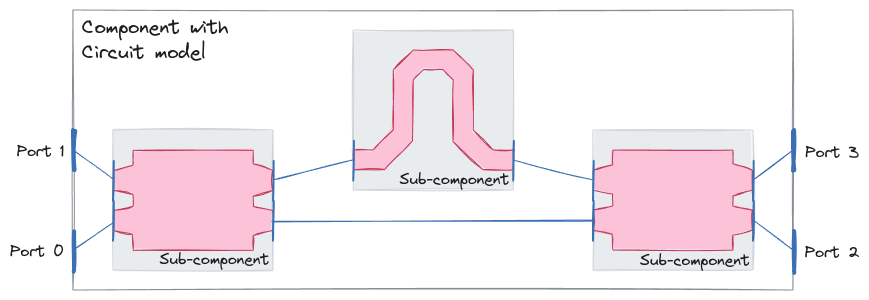

These connections are defined by analyzing all ports directly.
We can verify the connections in our example by checking the main component's [netlist](../_autosummary/photonforge.Component.rst#photonforge.Component.get_netlist):

In [3]:
main_component.get_netlist()

{'instances': [Reference(component="SUB1", origin=(0, 0), rotation=0, scaling=1, x_reflection=False, repetition=Repetition(columns=1, rows=1, spacing=(0, 0))),
  Reference(component="SUB2", origin=(1, 0), rotation=0, scaling=1, x_reflection=False, repetition=Repetition(columns=1, rows=1, spacing=(0, 0)))],
 'ports': {(0, 'P0', 1): 'Port 0', (1, 'P1', 1): 'Port 1'},
 'connections': [((0, 'P1', 1), (1, 'P0', 1))],
 'virtual connections': []}

We can see that the main component's netlist contains 2 sub-components (from the `"instances"` list) and 1 connection (`"connections"` list).
The connection is between port P1 of `instances[0]` (with 1 mode) to port P0 of `instances[1]` (with 1 mode).
We also see the how instances' ports map to the main component's ports: port P0 from `instances[0]` (with 1 mode) maps to "Port 0", and port P1 from `instances[1]` (with 1 mode) maps to "Port 1".

It is not necessary to perform this manual check before using the Circuit model.
Any disconnected ports (in the main or sub-components) will generate a warning when computing the S matrix.
Note that, depending on the connection directions, mode solver runs are required to accommodate polarization-dependent phase offsets between sub-components.

In [4]:
main_component.add_model(pf.CircuitModel(), "Circuit")

main_component.s_matrix([pf.C_0 / 1.55])

Starting...
Loading cached simulation from .tidy3d/pf_cache/JM4/ms_info-CJAMWJENFTNTZQELR7FQPPHFZHXFUWWMXRR22XYCGJ6IYRTEBSTA.json.
Progress: 100% 


SMatrix(frequencies=[1.93414e+14], elements={('Port 1@0', 'Port 0@0'): [-0.160536-0.98703j], ('Port 0@0', 'Port 1@0'): [-0.160536-0.98703j]}, ports={'Port 0': Port(center=(0, 0), input_direction=0, spec=PortSpec(description="Strip waveguide", width=2.25, limits=(-1, 1.22), num_modes=1, polarization="", target_neff=4, path_profiles={(2.5, 0, (1, 0)), (0.5, 0, (2, 0))}), extended=True, inverted=False), 'Port 1': Port(center=(3, 0), input_direction=180, spec=PortSpec(description="Strip waveguide", width=2.25, limits=(-1, 1.22), num_modes=1, polarization="", target_neff=4, path_profiles={(2.5, 0, (1, 0)), (0.5, 0, (2, 0))}), extended=True, inverted=True)})

## Virtual Connections

In the netlist we inspected earlier, there is another item, `"virtual connections"`, which was not used.
Virtual connections can be employed to force connections between components that are not physically connected in the layout.
That can be used to create circuit simulations without having to layout and route all sub-components.

Let's use analytic models and virtual connections to quickly create an interferometer response.
Because we're using completely analytic models for the sub-components, they only need the correct number of ports to work.
The geometrical contents are not utilized by the model, so we can leave them empty.

In [5]:
coupler = pf.Component("COUPLER")

# Create 4 ports required by the directional coupler model. Exact positions and rotations are
# irrelevant for virtual connections, as long as the ports are not physically connected.
coupler.add_port([pf.Port((i // 2, i % 2), i // 2 * 180, "Strip") for i in range(4)])

# Add some geometry just for visualization
coupler.add(pf.Rectangle((0, -1), (1, 2)))

coupler.add_model(pf.DirectionalCouplerModel(), "Analytic")
coupler

In [6]:
delay = pf.Component("DELAY")

# Create 2 ports required by the waveguide model
delay.add_port([pf.Port((i, 0), i * 180, "Strip") for i in range(2)])

# Add some geometry just for visualization
delay.add(pf.Rectangle((0, -0.5), (1, 0.5)))

delay.add_model(pf.WaveguideModel(n_complex=2, length=10), "Analytic")
delay

Now we build the main interferometer.
We only need to take care not to accidentally connect any ports in the physical layout, because real connections will override any virtual connections we make later.
Then, virtual connections can be easily [added between references](../_autosummary/photonforge.Component.rst#photonforge.Component.add_virtual_connection):

In [7]:
interferometer = pf.Component("INTERFEROMETER")

ref1 = interferometer.add_reference(coupler)
ref2 = interferometer.add_reference(coupler).translate((4, 0))
ref3 = interferometer.add_reference(delay).translate((2, 1.5))
ref4 = interferometer.add_reference(delay).translate((2, -0.5))

interferometer.add_port([ref1["P0"], ref1["P1"], ref2["P2"], ref2["P3"]], "Port ")

interferometer.add_virtual_connection(ref1, "P2", ref4, "P0")
interferometer.add_virtual_connection(ref4, "P1", ref2, "P0")
interferometer.add_virtual_connection(ref1, "P3", ref3, "P0")
interferometer.add_virtual_connection(ref3, "P1", ref2, "P1")

interferometer

We can take a look at the netlist to check the virtual connections:

In [8]:
interferometer.get_netlist()

{'instances': [Reference(component="COUPLER", origin=(0, 0), rotation=0, scaling=1, x_reflection=False, repetition=Repetition(columns=1, rows=1, spacing=(0, 0))),
  Reference(component="COUPLER", origin=(4, 0), rotation=0, scaling=1, x_reflection=False, repetition=Repetition(columns=1, rows=1, spacing=(0, 0))),
  Reference(component="DELAY", origin=(2, 1.5), rotation=0, scaling=1, x_reflection=False, repetition=Repetition(columns=1, rows=1, spacing=(0, 0))),
  Reference(component="DELAY", origin=(2, -0.5), rotation=0, scaling=1, x_reflection=False, repetition=Repetition(columns=1, rows=1, spacing=(0, 0)))],
 'ports': {(0, 'P0', 1): 'Port 0',
  (0, 'P1', 1): 'Port 1',
  (1, 'P2', 1): 'Port 2',
  (1, 'P3', 1): 'Port 3'},
 'connections': [],
 'virtual connections': [((3, 'P1', 1), (1, 'P0', 1)),
  ((2, 'P1', 1), (1, 'P1', 1)),
  ((0, 'P2', 1), (3, 'P0', 1)),
  ((0, 'P3', 1), (2, 'P0', 1))]}

Although both delay references use the same component, we can set by-instance model updates, such that when the circuit model computes the S parameters for each one, they will have different responses.
We can set these specific parameters through the `updates` keyword argument available in the Circuit model's [start](../_autosummary/photonforge.CircuitModel.rst#photonforge.CircuitModel.start) method.

In this case, we chose to apply a *model update* to the second delay reference, specified by the tuple `("DELAY", 1)` with the targeted component name and instance number (0 would be the first reference with a component named DELAY, and so on).

Starting...
Progress: 100% 


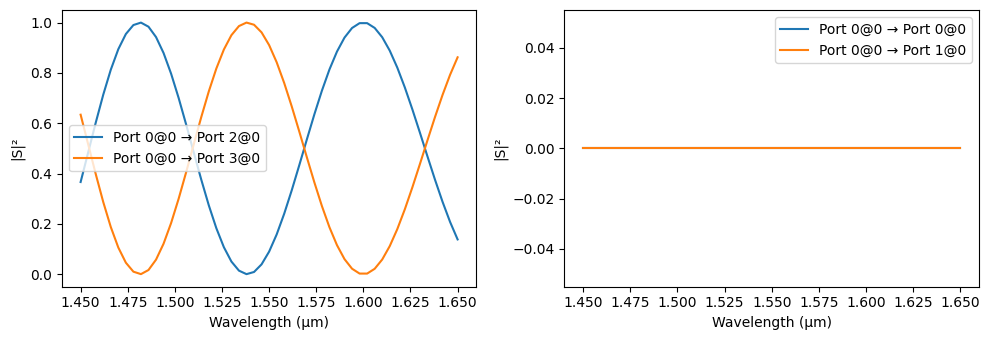

In [9]:
interferometer.add_model(pf.CircuitModel(), "Circuit")
reference_updates = {
    ("DELAY", 1): {"model_updates": {"length": 20}},
}

s_matrix = interferometer.s_matrix(
    pf.C_0 / np.linspace(1.45, 1.65, 51), model_kwargs={"updates": reference_updates}
)

_ = pf.plot_s_matrix(s_matrix, input_ports=["Port 0"])

Note that after each computation, the model parameters are reset to their original values:

In [10]:
delay.active_model.length

10

## Component From Netlist

The same component could have been created from a netlist description using the [component_from_netlist](../_autosummary/photonforge.component_from_netlist.rst) function.

As an example, in this case we directly set the [model_updates](../_autosummary/photonforge.Reference.rst#photonforge.Reference.model_updates) attribute of one of the delay references, so that will be used automatically by the Circuit model.
Other attributes that can be used for similar purposes are [technology_updates](../_autosummary/photonforge.Reference.rst#photonforge.Reference.technology_updates) and [component_updates](../_autosummary/photonforge.Reference.rst#photonforge.Reference.component_updates).

Starting...
Progress: 100% 


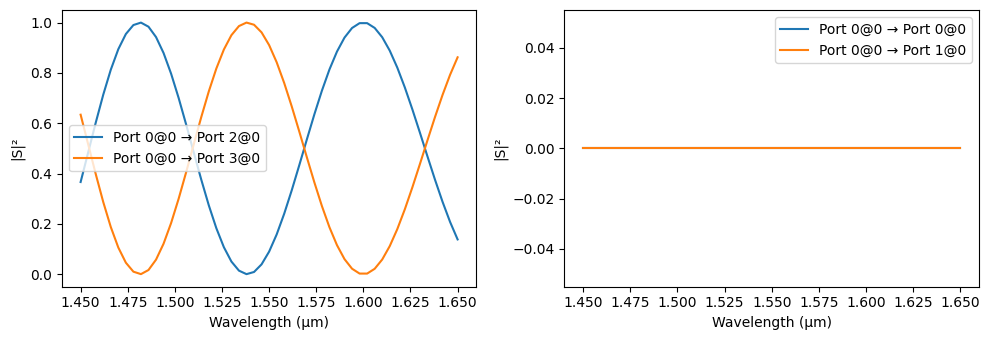

In [11]:
interf2 = pf.component_from_netlist(
    {
        "instances": {
            "Coupler1": coupler,
            "Coupler2": {"component": coupler, "origin": (4, 0)},
            "Delay1": {"component": delay, "origin": (2, 1.5)},
            "Delay2": {
                "component": delay,
                "origin": (2, -0.5),
                "model_updates": {"length": 20},
            },
        },
        "ports": [
            ("Coupler1", "P0", "Port 0"),
            ("Coupler1", "P1", "Port 1"),
            ("Coupler2", "P2", "Port 2"),
            ("Coupler2", "P3", "Port 3"),
        ],
        "virtual connections": [
            (("Coupler1", "P2"), ("Delay2", "P0")),
            (("Coupler2", "P0"), ("Delay2", "P1")),
            (("Coupler1", "P3"), ("Delay1", "P0")),
            (("Coupler2", "P1"), ("Delay1", "P1")),
        ],
        "models": [(pf.CircuitModel(), "Circuit")],
    }
)

s_matrix2 = interf2.s_matrix(pf.C_0 / np.linspace(1.45, 1.65, 51))
_ = pf.plot_s_matrix(s_matrix2, input_ports=["Port 0"])